In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import numpy as np
import beadpy
import pandas as pd

In [483]:
%matplotlib notebook

In [556]:
def trajectory_simulator(pre_duration = 250, #Mean event start time
                         pre_sigma = 50, #Sigma of event start time distribution
                         post_duration = 250, #The bead stays on for this long at the end of the trajectory
                         mean_duration = 100, #Mean event duration
                         min_duration = 10, #Minimum event duration
                         mean_rate = 500, #Mean rate (distance units/timestep)
                         rate_sigma = 50, #Sigma of the rate distribution
                         noise_sigma = 500, #Mean sigma for the bead movement
                         noise_sigma_sigma = 100, #Sigma of the noise sigma distribution
                         pause_prob = 0.001, #Probability of entering a pause in a given timestep
                         pause_duration_prob = 0.2, #Probability of remaining paused in a given timestep once a pause has begun.
                         rate_change_prob = 0.1, #Probablity that the rate will change in a given timestep
                         DNA_length = 15000, #Length of the DNA - a hard limit on the event length
                         trajectory_number = 0):
    length = int(np.random.exponential(mean_duration))
    initlength = length
    while length < min_duration:
        length = int(np.random.exponential(mean_duration))
        
    current_rate = 0
    pre = int(np.random.normal(loc=pre_duration, scale = pre_sigma))
    post = post_duration
    rate = 0
    ratesequence = [0]*pre
    noise_sigmaval = int(np.random.normal(loc=noise_sigma, scale = noise_sigma_sigma))
    position = [0]*pre
    nucleotides = []
    current_position = 0
    pause_counter = 0
    pause_time = []
    for i in range(0,pre):
        nucleotides.append(float(position[i]+np.random.normal(loc=0.0, scale = noise_sigmaval)))
    for i in range(0,length):
        pause = random.random() #generate a random float between 0 and 1
        if not rate == 0: #When during an event/no pause.
            if (pause <= pause_prob): #Start a pause
                rate = 0
                pause_counter = pause_counter + 1
                pause_time.append(i + pre)
            elif (pause > pause_prob) & (pause <= (pause_prob + rate_change_prob)): #Change the rate
                current_rate = np.random.normal(loc=mean_rate, scale = rate_sigma)
                rate = current_rate
            else: #No rate change
                rate = current_rate          
        elif (rate == 0) & (not i ==0): #When in a pause
            if (pause < (1- pause_duration_prob)): #End the pause
                rate = np.random.normal(loc=mean_rate, scale = rate_sigma)
            else:
                rate = 0 #Continue the pause
        elif i == 0: #Start the event
            current_rate = np.random.normal(loc=mean_rate, scale = rate_sigma)
            rate = current_rate
        ratesequence.append(rate)
        current_position = current_position + rate
        position.append(current_position)
        nucleotides.append(float(current_position+np.random.normal(loc=0.0, scale = noise_sigmaval)))
        if current_position > DNA_length:
            length = i
            break
    for i in range(0,post):
        ratesequence.append(0)
        position.append(current_position)
        nucleotides.append(float(current_position+np.random.normal(loc=0.0, scale = noise_sigmaval)))
    time = range(0,len(nucleotides))
    results = pd.DataFrame({'time' : time,
                        'nucleotides' : nucleotides,
                           'rate' : ratesequence,
                           'position' : position})
    results['trajectory'] = trajectory_number
    return results #, length, initlength, pause_counter, pause_time

<IPython.core.display.Javascript object>


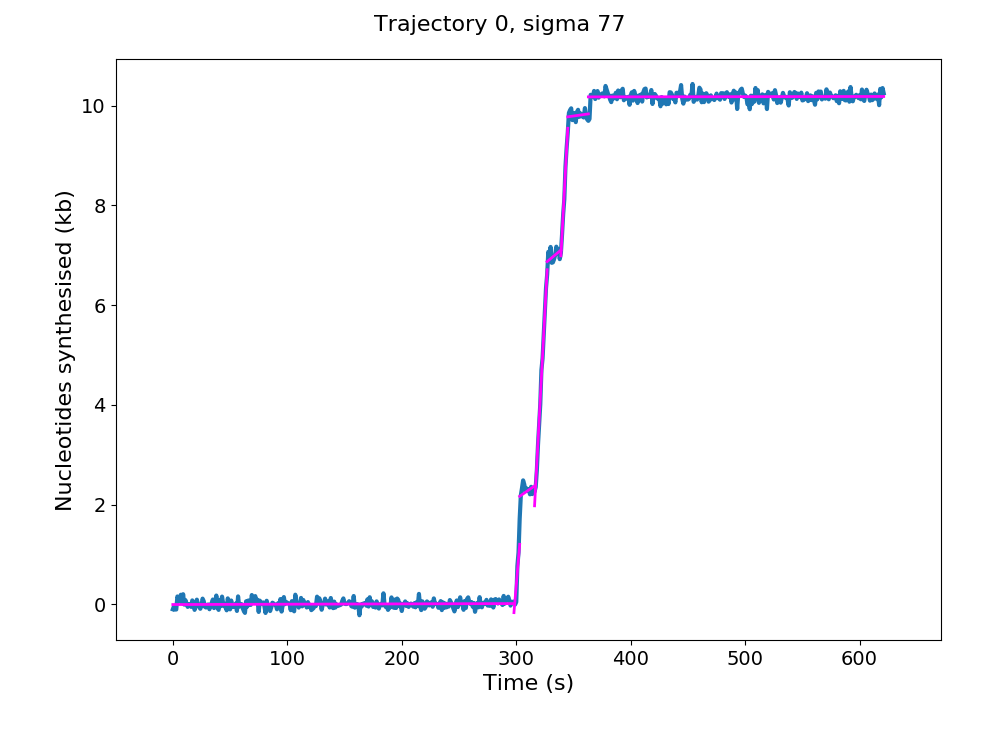

In [575]:
test = trajectory_simulator(pre_duration = 300,
                         pre_sigma = 5,
                         post_duration = 250, 
                         mean_duration = 100,
                         min_duration = 10,
                         mean_rate = 450,
                         rate_sigma = 100,
                         noise_sigma = 100,
                         noise_sigma_sigma = 20,
                         pause_prob = 0.1,
                         pause_duration_prob = 0.9,
                         rate_change_prob = 0.2,
                         DNA_length = 15000,
                         trajectory_number = 0)
exampletrajseg = beadpy.trajectory_plotter(test, 0, method = ('auto', 'whole'), 
                                           sigma_start = 10, sigma_end = 250,  
                                           eventregion = (200,500), 
                                           segmenttable = 0)

In [576]:
exampletrajseg

,rate,intercept,x1,x2,y1,y2,displacement,duration,trajectory
0,0.1,-5.0,0.0,298.0,-5.1,13.9,19.0,298.0,0.0
1,274.2,-81870.0,298.0,303.0,-167.8,1203.0,1370.8,5.0,0.0
2,16.0,-2672.0,303.0,316.0,2165.8,2373.4,207.6,13.0,0.0
3,430.6,-134090.0,316.0,327.0,1975.2,6711.6,4736.4,11.0,0.0
4,19.1,619.0,327.0,339.0,6874.9,7104.5,229.6,12.0,0.0
5,426.6,-137637.0,339.0,345.0,6990.4,9550.2,2559.8,6.0,0.0
6,3.3,8656.0,345.0,363.0,9778.7,9837.3,58.6,18.0,0.0
7,0.0,10167.0,363.0,621.0,10178.7,10186.8,8.1,258.0,0.0


Compare the table of actual changepoints below (ignoring rate changes of less than 10) with the above table of the discovered changepoints above.

In [577]:
changepoints = []
changepoint_values = []
for i in test.time[1:]:
    if abs(test.rate[i] - test.rate[i-1]) > 10:
        changepoints.append(i)
        changepoint_values.append(test.rate[i])
cpts = pd.DataFrame({'changepoint' : changepoints,
                    'rate' : changepoint_values})
cpts

,changepoint,rate
0,301,583.492354
1,305,0.000000
2,318,286.325508
3,319,512.598708
4,323,369.272194
5,325,424.076504
6,328,333.054037
7,329,0.000000
8,340,486.875466
9,341,333.054037


Generate a large results table.

In [566]:
results = pd.DataFrame()
for j in range(0,1000):
    temp = trajectory_simulator(pre_duration = 400,
                         pre_sigma = 50,
                         post_duration = 250, 
                         mean_duration = 100,
                         min_duration = 10,
                         mean_rate = 450,
                         rate_sigma = 100,
                         noise_sigma = 100,
                         noise_sigma_sigma = 20,
                         pause_prob = 0.1,
                         pause_duration_prob = 0.9,
                         rate_change_prob = 0.05,
                         DNA_length = 15000,
                         trajectory_number = j)
    results = results.append(temp)

In [567]:
segments = beadpy.segment_finder(results, method = 'auto', sigma_start=10, sigma_end=250)

<IPython.core.display.Javascript object>


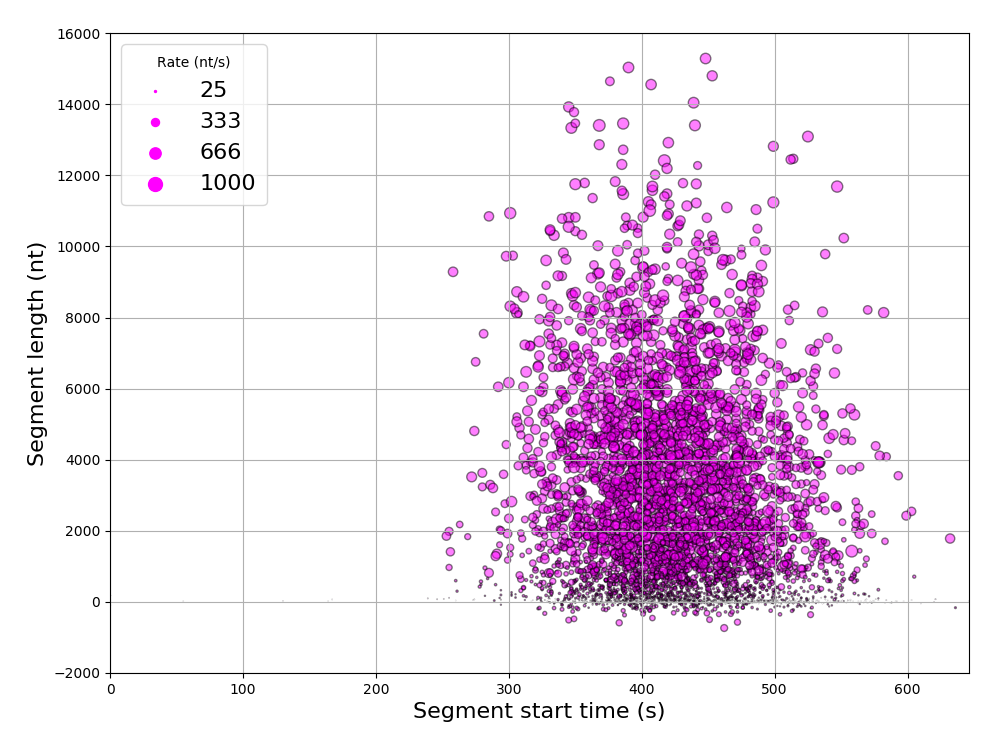

In [569]:
beadpy.segmentplotter(segments,1000,-2000,16000, 2, 10)